## Table of Contents
<a id='section0'></a>
<div class="alert alert-block alert-info" style="margin-top: 20px">


<a href='#section1'> 1. Prepare New York dataset </a>
    
<a href='#section2'> 2. Prepare Toronto dataset</a>
    
<a href='#section3'> 3. Prepare Paris dataset</a>
    
<a href='#section4'> 4. 'Foursqure' nearby venues in three analysis cities</a>
    
<a href='#section5'> 5. Combine the datasets of three cities</a>
    
<a href='#section6'> 6. Datasets analysis</a>
    
<a href='#section7'> 7. Clustering</a>
    
</font>
</div>

### Introduction
If you were to open up a new business, there are many confusing issues. Among which, the dominant issue is where to go?

### Business Problem
To open up a new restaurant or other businesses in cities (New York, Toronto or Paris), which City / Borough / Neighborhood should we choose to better harness its location attractiveness and strengths ?

### Goals & Methodology
1)City analysis: we sourced and cleaned data to find out how many place of venues are there, which may tell us the venue scale of each city. Furthermore, we can analyze the variety of venues in each city, which may tell us how diverse the city venues can be and how correlated between cities. 

In order to reach the goals, we combined all city datasets together to do the clustering analysis, we want to find out how the machine learning distribute all cities venues, and specifically in each cluster how new_york, paris and toronto venues are distributed? The underlying assumption is that if two cities are alike, their distribution among clusters should be similar.

2)Borough / Neighborhood analysis: we use FourSqure data to analyze the top 10 venues in each neighborhood, so that we can find the behind story of what types of businesses are popular there. The underlying philosophy here is the neighborhood market may have sufficient capacity and willingness to welcome a new restaurant if the already existing restaurants here are placed as the 1st popular places of venues.

### Data sources:

New York 1.1 Neighborhood data: https://geo.nyu.edu/catalog/nyu_2451_34572 1.2 Venue data nearby: Foursquare API

Toronto 2.1 Neighborhood data; Wiki, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 2.2 Venue data nearby: Foursquare API

Paris 3.1 Neighborhood data: Wikipedia, https://en.wikipedia.org/wiki/Arrondissements_of_Paris 3.2 Venue data nearby: Foursqure

### Conclustions:
1) As we compare New York with cities of Toronto and Paris overally, in terms of city diversity, New York is more similar to Toronto;

2) As we compare specific ares of New York (Manhattan) with Toronto ('Downtown Toronto','East Toronto','West Toronto','Central Toronto') and Paris ('Butte-Montmartre','Elysee','Vaugirard'), New York is more alike with Paris;

3) In terms of New York:
#select all New York datasets in cluster 0, the evident theme is "Deli / Bodega"
#select all New York datasets in cluster 1, non-Manhattan boroughs are evident, let's take Brooklyn as an example, here you can find in Brooklyn theme "Caribbean restaurant"
#select all New York datasets in cluster 4, here you can find in Manhattan theme "foreign restaurant", Brooklyn theme "Pizza & Bar"

4) In terms of Toronto:
#select all Toronto datasets in cluster 4, for example, the evident theme is "Cafe" in Toronto downtown
#select all Toronto datasets in cluster 1, you will find groups outside'Downtown Toronto','East Toronto','West Toronto' and 'Central Toronto' are more evident, the theme mainly includes "Foreign restaurants"

5) In terms of Paris:
#select all datasets in cluster 4, in Paris boroughs of 'Butte-Montmartre','Elysee' and 'Vaugirard' as an example, the major theme is "French restaurant & hotel"


Import all dependencies needed

In [8]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import random
from bs4 import BeautifulSoup as bs
import html5lib

from IPython.display import Image
from IPython.core.display import HTML

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import re

print('Libraries imported.')

Libraries imported.


In [9]:
# create a function to output all venues nearby the specified location.

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=101):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
CLIENT_ID = 'FOACYMUX51FQS2WK3PFCG0JDNCVCLQK2BQJ2ORMDJA2T5BFI' # your Foursquare ID
CLIENT_SECRET = 'TKK4DH2VJSWYXY53QFUFU4RBPU02ING44V0QOA1QJRKTS2T2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FOACYMUX51FQS2WK3PFCG0JDNCVCLQK2BQJ2ORMDJA2T5BFI
CLIENT_SECRET:TKK4DH2VJSWYXY53QFUFU4RBPU02ING44V0QOA1QJRKTS2T2


<a id='section1'></a>
## 1. Prepare New York dataset

<a href='#section0'> or Go back to Table of Contents </a>

In [11]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [12]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [13]:
neighborhoods.insert(0,'City',value='New_york',allow_duplicates = False)
neighborhoods.insert(1,'City_code',value=0,allow_duplicates = False)
all_newyork_neighborhoods=neighborhoods

In [14]:
print('the shape of dataset is {}'.format(all_newyork_neighborhoods.shape))
all_newyork_neighborhoods.head()

the shape of dataset is (306, 6)


,City,City_code,Borough,Neighborhood,Latitude,Longitude
0,New_york,0,Bronx,Wakefield,40.894705,-73.847201
1,New_york,0,Bronx,Co-op City,40.874294,-73.829939
2,New_york,0,Bronx,Eastchester,40.887556,-73.827806
3,New_york,0,Bronx,Fieldston,40.895437,-73.905643
4,New_york,0,Bronx,Riverdale,40.890834,-73.912585


In [19]:
# We choose 306 sample neighborhoods in New York.
newyork_neighborhoods_input=all_newyork_neighborhoods.sample(n=306)

<a id='section2'></a>
## 2. Prepare Toronto dataset

<a href='#section0'> or Go back to Table of Contents </a>

In [20]:
# import dataframe from file of toronto_data
toronto_df = pd.read_csv('toronto_data.csv')

# rename the columns accordingly
toronto_df.columns=['PostalCode','Borough','Neighborhood']

df_nadrop=toronto_df[toronto_df['Borough']!='Not assigned']
df_nadrop.reset_index(drop=True,inplace=True)
df_middle=df_nadrop

# set up the function to replace / with ,
def change_character(words):
    new_words=re.sub("\s/\s", ", ", words)
    return new_words

# use already built function to replace all '/' with ","
length=len(df_middle)
for i in np.arange(length):
    old=df_middle.loc[i,'Neighborhood']
    new=change_character(str(old))
    df_middle.loc[i,'Neighborhood']=str(new)

geo_inforn = pd.read_csv('Geospatial_Coordinates.csv')

df_merge=df_middle.join(geo_inforn.set_index('Postal Code'),on='PostalCode')

df_toronto_beforeinsert=df_merge.drop('PostalCode',1)

df_toronto_beforeinsert.insert(0,'City',value='Toronto',allow_duplicates=False)

df_toronto_beforeinsert.insert(1,'City_code',value=1,allow_duplicates=False)

all_toronto_neighborhoods=df_toronto_beforeinsert

C:\Users\boxin\Miniconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\boxin\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
print('the shape of dataset is {}'.format(all_toronto_neighborhoods.shape))

all_toronto_neighborhoods.head()

the shape of dataset is (103, 6)


,City,City_code,Borough,Neighborhood,Latitude,Longitude
0,Toronto,1,North York,Parkwoods,43.753259,-79.329656
1,Toronto,1,North York,Victoria Village,43.725882,-79.315572
2,Toronto,1,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,1,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [22]:
# We choose 103 sample neighborhoods in New York.
toronto_neighborhoods_input=all_toronto_neighborhoods.sample(n=103)

<a id='section3'></a>
## 3. Prepare Paris dataset

<a href='#section0'> or Go back to Table of Contents </a>

In [25]:
# import dataframe from file of Paris_geo, which was sourced from "https://en.wikipedia.org/wiki/Arrondissements_of_Paris" as of 12th Apr, 2020.
paris_df = pd.read_csv('paris_geo.csv')
middle_inparis=paris_df

middle_inparis.insert(0,'City',value='Paris',allow_duplicates=False)

middle_inparis.insert(1,'City_code',value=2,allow_duplicates=False)

all_paris_neighborhoods=middle_inparis

In [26]:
print('the shape of dataset is {}'.format(all_paris_neighborhoods.shape))
all_paris_neighborhoods.head()

the shape of dataset is (29, 6)


,City,City_code,Borough,Neighborhood,Latitude,Longitude
0,Paris,2,Louvre,Louvre,48.8606,2.3376
1,Paris,2,Bourse,Bourse,48.8687,2.3412
2,Paris,2,Temple,Temple,48.8659,2.3611
3,Paris,2,Hotel-de-Ville,Hotel-de-Ville,48.8534,2.3583
4,Paris,2,Pantheon,Pantheon,48.8462,2.3464


In [27]:
paris_neighborhoods_input=all_paris_neighborhoods

<a id='section4'></a>
## 4. 'Foursqure' nearby venues in three analysis cities

<a href='#section0'> or Go back to Table of Contents </a>

In [28]:
paris_venues = getNearbyVenues(names=paris_neighborhoods_input['Neighborhood'],
                                   latitudes=paris_neighborhoods_input['Latitude'],
                                   longitudes=paris_neighborhoods_input['Longitude']
                                  )

Louvre
Bourse
Temple
Hotel-de-Ville
Pantheon
Luxembourg
Palais-Bourbon
Quartier des Champs-Elysees
Quartier du Faubourg-du-Roule
Quartier de la Madeleine
Quartier de l'Europe
Opera
Entrepot
Popincourt
Reuilly
Gobelins
Observatoire
Javel
Grenelle
Necker 
Saint-Lambert
Passy
Batignolles-Monceau
Quartier de La Chapelle
Goutte d'Or
Pigalle
Montmartre
Buttes-Chaumont
Menilmontant


In [30]:
print('the shape of dataset is {}'.format(paris_venues.shape))
paris_venues.head()

the shape of dataset is (1844, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Louvre,48.8606,2.3376,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza
1,Louvre,48.8606,2.3376,Musée du Louvre,48.860847,2.336440,Art Museum
2,Louvre,48.8606,2.3376,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit
3,Louvre,48.8606,2.3376,Cour Napoléon,48.861172,2.335088,Plaza
4,Louvre,48.8606,2.3376,Pont des Arts,48.858565,2.337635,Bridge


In [31]:
paris_venues.to_csv(r'C:\Users\boxin\Desktop\py4e\5_Applied_Data_Science_Capstone\paris_venues.csv',index=False)

In [32]:
newyork_venues = getNearbyVenues(names=newyork_neighborhoods_input['Neighborhood'],
                                   latitudes=newyork_neighborhoods_input['Latitude'],
                                   longitudes=newyork_neighborhoods_input['Longitude']
                                  )

Tottenville
West Brighton
Canarsie
Roosevelt Island
Emerson Hill
Utopia
Park Hill
Bergen Beach
East Williamsburg
Belmont
Arlington
St. Albans
Lindenwood
Flatiron
Auburndale
Remsen Village
Prospect Heights
City Line
Silver Lake
Arden Heights
City Island
Wingate
Kew Gardens Hills
Queensbridge
Lighthouse Hill
Country Club
Williamsburg
Sandy Ground
Longwood
Malba
Eastchester
Bayside
Breezy Point
East Harlem
Marine Park
Soundview
Bulls Head
Mott Haven
Fort Hamilton
Woodside
Cambria Heights
Stapleton
Sunnyside
Dyker Heights
Fordham
Port Ivory
Lenox Hill
Upper East Side
Elm Park
Butler Manor
Egbertville
Borough Park
Dongan Hills
Concord
Coney Island
Howard Beach
Bay Terrace
Rockaway Park
Baychester
Concourse
Jackson Heights
Hunters Point
Mill Island
University Heights
Shore Acres
Castleton Corners
Manor Heights
Claremont Village
Brownsville
Beechhurst
Glendale
Briarwood
Astoria Heights
New Dorp
Howland Hook
New Lots
Pelham Parkway
Marble Hill
Boerum Hill
Queensboro Hill
Brookville
Mount Eden


In [33]:
print('the shape of dataset is {}'.format(newyork_venues.shape))
newyork_venues.head()

the shape of dataset is (10071, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tottenville,40.505334,-74.246569,MTA Bus - Hylan Bl & Brighton/Chelsea Sts (S59...,40.504382,-74.242467,Bus Stop
1,Tottenville,40.505334,-74.246569,Main Street Deli And Grocery,40.508958,-74.246908,Deli / Bodega
2,Tottenville,40.505334,-74.246569,Don Cesar Mexican,40.508984,-74.246680,Mexican Restaurant
3,Tottenville,40.505334,-74.246569,Villaggio,40.509285,-74.246597,Italian Restaurant
4,Tottenville,40.505334,-74.246569,Beauty Nail,40.509327,-74.246475,Cosmetics Shop


In [34]:
newyork_venues.to_csv(r'C:\Users\boxin\Desktop\py4e\5_Applied_Data_Science_Capstone\newyork_venues.csv',index=False)

In [35]:
toronto_venues = getNearbyVenues(names=toronto_neighborhoods_input['Neighborhood'],
                                   latitudes=toronto_neighborhoods_input['Latitude'],
                                   longitudes=toronto_neighborhoods_input['Longitude']
                                  )

York Mills, Silver Hills
North Toronto West
The Beaches
Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East
Birch Cliff, Cliffside West
Milliken, Agincourt North, Steeles East, L'Amoreaux East
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Scarborough Village
Alderwood, Long Branch
The Annex, North Midtown, Yorkville
India Bazaar, The Beaches West
Guildwood, Morningside, West Hill
Runnymede, The Junction North
Victoria Village
St. James Town, Cabbagetown
Woodbine Heights
Parkwoods
Lawrence Park
North Park, Maple Leaf Park, Upwood Park
Downsview
Central Bay Street
Regent Park, Harbourfront
Islington Avenue
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Willowdale, Newtonbrook
First Canadian Place, Underground city
Business reply mail Processing CentrE
Davisville North
Hillcrest Village
Summerhill West, Rathnelly, South Hil

In [37]:
print('the shape of dataset is {}'.format(toronto_venues.shape))
toronto_venues.head()

the shape of dataset is (2146, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Toronto West,43.715383,-79.405678,Barreworks,43.714070,-79.400109,Yoga Studio
1,North Toronto West,43.715383,-79.405678,Nailsense,43.717467,-79.400653,Spa
2,North Toronto West,43.715383,-79.405678,C'est Bon,43.716785,-79.400406,Chinese Restaurant
3,North Toronto West,43.715383,-79.405678,Civello Salon,43.715111,-79.400304,Salon / Barbershop
4,North Toronto West,43.715383,-79.405678,Uncle Betty's Diner,43.714452,-79.400091,Diner


In [38]:
toronto_venues.to_csv(r'C:\Users\boxin\Desktop\py4e\5_Applied_Data_Science_Capstone\toronto_venues.csv',index=False)

In [48]:
# Density: the no. of venues per unit of neighborhood in New_york
print('the no. of venues per unit of neighborhood in New York is {}'.format(newyork_venues.shape[0]/newyork_neighborhoods_input.shape[0]))

# Density: the no. of venues per unit of neighborhood in Toronto
print('the no. of venues per unit of neighborhood in Toronto is {}'.format(toronto_venues.shape[0]/toronto_neighborhoods_input.shape[0]))

# Density: the no. of venues per unit of neighborhood in Paris
print('the no. of venues per unit of neighborhood in Paris is {}'.format(paris_venues.shape[0]/paris_neighborhoods_input.shape[0]))

the no. of venues per unit of neighborhood in New York is 32.911764705882355
the no. of venues per unit of neighborhood in Toronto is 20.83495145631068
the no. of venues per unit of neighborhood in Paris is 63.58620689655172


<a id='section5'></a>
## 5. Combine the datasets of three cities

<a href='#section0'> or Go back to Table of Contents </a>

In [45]:
newyork_datasets=newyork_neighborhoods_input.join(newyork_venues.set_index('Neighborhood'),on='Neighborhood')

paris_datasets=paris_neighborhoods_input.join(paris_venues.set_index('Neighborhood'),on='Neighborhood')

toronto_datasets=toronto_neighborhoods_input.join(toronto_venues.set_index('Neighborhood'),on='Neighborhood')

In [46]:
newyork_paris_datasets=pd.concat([newyork_datasets,paris_datasets])
all_datasets=pd.concat([newyork_paris_datasets,toronto_datasets])
all_datasets.reset_index(drop=True,inplace=True)
print("the shape of the dataframe merging all three cities' data together is {}".format(all_datasets.shape))

the shape of the dataframe merging all three cities' data together is (14522, 12)


In [50]:
all_datasets.head()

,City,City_code,Borough,Neighborhood,Latitude,Longitude,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New_york,0,Staten Island,Tottenville,40.505334,-74.246569,40.505334,-74.246569,MTA Bus - Hylan Bl & Brighton/Chelsea Sts (S59...,40.504382,-74.242467,Bus Stop
1,New_york,0,Staten Island,Tottenville,40.505334,-74.246569,40.505334,-74.246569,Main Street Deli And Grocery,40.508958,-74.246908,Deli / Bodega
2,New_york,0,Staten Island,Tottenville,40.505334,-74.246569,40.505334,-74.246569,Don Cesar Mexican,40.508984,-74.246680,Mexican Restaurant
3,New_york,0,Staten Island,Tottenville,40.505334,-74.246569,40.505334,-74.246569,Villaggio,40.509285,-74.246597,Italian Restaurant
4,New_york,0,Staten Island,Tottenville,40.505334,-74.246569,40.505334,-74.246569,Beauty Nail,40.509327,-74.246475,Cosmetics Shop


<a id='section6'></a>
## 6. Datasets analysis

<a href='#section0'> or Go back to Table of Contents </a>

In [51]:
onehot=pd.get_dummies(all_datasets[['Venue Category']], prefix="", prefix_sep="")

# drop the column'neighborhood'
onehot.drop(['Neighborhood'],axis=1,inplace=True)

# insert the neighborhood column into onehot's first column
onehot.insert(0,'Neighborhood',all_datasets['Neighborhood'],allow_duplicates = True)
onehot.insert(1,'City',all_datasets['City'],allow_duplicates = True)
onehot.insert(2,'City_code',all_datasets['City_code'],allow_duplicates = True)
onehot.insert(3,'Borough',all_datasets['Borough'],allow_duplicates = True)

print('the shape of the onehot is {}'.format(onehot.shape))
onehot.head()

#onehot['City_code'].value_counts()

the shape of the onehot is (14522, 476)


,Neighborhood,City,City_code,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Lyonese Bouchon,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mat

In [52]:
analysis_group=onehot.drop(['City','City_code','Borough'],axis=1).groupby('Neighborhood').mean().reset_index()
print('the shape of group is {}'.format(analysis_group.shape))
analysis_group.head(10)

the shape of group is (428, 473)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Lyonese Bouchon,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Cen

In [79]:
#Creat the dataframe containing neighborhood, city_code, borough, as well as its neighborhood's dummy variables

left_group=analysis_group[['Neighborhood']]
print(left_group.shape)

right_group=onehot[['Neighborhood','City_code','Borough']]
print(right_group.shape)


left_group.insert(1,'City_code',value=5)
left_group.insert(2,'Borough',value='New')

for i,item in enumerate(left_group.Neighborhood):
    solution1=right_group[right_group['Neighborhood']==item].iloc[0][1]
    solution=right_group[right_group['Neighborhood']==item].iloc[0][2]
    left_group['City_code'][i]=solution1
    left_group['Borough'][i]=solution

if (analysis_group['City_code'] == None)[0]:
    analysis_group.insert(1,'City_code',left_group['City_code'])
else:
    analysis_group.drop('City_code',axis=1,inplace=True)
    analysis_group.insert(1,'City_code',left_group['City_code'])

if (analysis_group['Borough'] == None)[0]:
    analysis_group.insert(2,'Borough',left_group['Borough'])
else:
    analysis_group.drop('Borough',axis=1,inplace=True)
    analysis_group.insert(2,'Borough',left_group['Borough'])   
    
#analysis_group.drop('City_code',axis=1,inplace=True)
#analysis_group.insert(1,'City_code',left_group['City_code'])

#analysis_group.drop('Borough',axis=1,inplace=True)
#analysis_group.insert(2,'Borough',left_group['Borough'])

(428, 1)
(14522, 3)


C:\Users\boxin\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\boxin\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
print('the shape of "analysis_group" is {}'.format(analysis_group.shape))
analysis_group.head(10)

the shape of "analysis_group" is (428, 475)


,Neighborhood,City_code,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Lyonese Bouchon,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress

In [84]:
# create a function to return the 10 most frequent venues for each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = analysis_group['Neighborhood']

for ind in np.arange(analysis_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(analysis_group.iloc[ind, 3:], num_top_venues)

print('the shape of neighborhoods_venues_sorted is {}'.format(neighborhoods_venues_sorted.shape))
neighborhoods_venues_sorted.head(10)

the shape of neighborhoods_venues_sorted is (428, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Latin American Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pub,Gym,Athletics & Sports,Sandwich Place,Coffee Shop,Pool,Pharmacy,English Restaurant
2,Allerton,Pizza Place,Supermarket,Chinese Restaurant,Deli / Bodega,Check Cashing Service,Grocery Store,Smoke Shop,Mexican Restaurant,Donut Shop,Gas Station
3,Annadale,Pizza Place,American Restaurant,Pharmacy,Train Station,Diner,Deli / Bodega,Dance Studio,Restaurant,Food,Sports Bar
4,Arden Heights,Home Service,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Factory,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
5,Arlington,Bus Stop,American Restaurant,Intersection,Deli / Bodega,Grocery Store,Falafel Restaurant,Factory,Eye Doctor,Exhibit,Yoga Studio
6,Arrochar,Deli / Bodega,Bus Stop,Italian Restaurant,Bagel Shop,Athletics & Sports,Sandwich Place,Pizza Place,Mediterranean Restaurant,Supermarket,Pharmacy
7,Arverne,Surf Spot,Metro Station,Sandwich Place,Donut Shop,Coffee Shop,Bed & Breakfast,Bus Stop,Pizza Place,Board Shop,Playground
8,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Deli / Bodega,Indian Restaurant,Mediterranean Restaurant,Bakery,Bagel Shop
9,Astoria Heights,Bus Station,Bakery,Business Service,Italian Restaurant,Bowling Alley,Burger Joint,Supermarket,Pizza Place,Plaza,Playground


<a id='section7'></a>
## 7. Clustering

<a href='#section0'> or Go back to Table of Contents </a>

In [88]:
# set number of clusters
kclusters = 5

all_group_cluster = analysis_group.drop('Neighborhood', 1).drop('City_code',1).drop('Borough',1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_group_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([4, 1, 1, 1, 1, 0, 0, 1, 4, 1, 4, 1, 1, 4, 4, 4, 4, 1, 4, 3])

In [94]:
# Form the final dataset which include each neighborhood's name, city_code, assigned_cluster_index, borough and top 10 venues.

fr=[analysis_group[['Neighborhood','City_code','Borough']],neighborhoods_venues_sorted.iloc[:,1:]]

final=pd.concat(fr,axis=1,sort=False)

final.insert(2,'Assigned_cluster_index',kmeans.labels_)

In [95]:
# Cluster distribution
final['Assigned_cluster_index'].value_counts()

4    231
1    158
0     27
3     11
2      1
Name: Assigned_cluster_index, dtype: int64

In [96]:
final.head()

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,1,4,Scarborough,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Latin American Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
1,"Alderwood, Long Branch",1,1,Etobicoke,Pizza Place,Skating Rink,Pub,Gym,Athletics & Sports,Sandwich Place,Coffee Shop,Pool,Pharmacy,English Restaurant
2,Allerton,0,1,Bronx,Pizza Place,Supermarket,Chinese Restaurant,Deli / Bodega,Check Cashing Service,Grocery Store,Smoke Shop,Mexican Restaurant,Donut Shop,Gas Station
3,Annadale,0,1,Staten Island,Pizza Place,American Restaurant,Pharmacy,Train Station,Diner,Deli / Bodega,Dance Studio,Restaurant,Food,Sports Bar
4,Arden Heights,0,1,Staten Island,Home Service,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Factory,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant


In [97]:
c1=final[final['Assigned_cluster_index']==4]['City_code'].value_counts()
c1

0    129
1     73
2     29
Name: City_code, dtype: int64

In [98]:
c0=final[final['Assigned_cluster_index']==1]['City_code'].value_counts()
c0

0    142
1     16
Name: City_code, dtype: int64

In [99]:
c2=final[final['Assigned_cluster_index']==0]['City_code'].value_counts()
c2

0    27
Name: City_code, dtype: int64

In [580]:
c3=final[final['Assigned_cluster_index']==3]['City_code'].value_counts()
c3

1    4
0    1
Name: City_code, dtype: int64

In [100]:
c4=final[final['Assigned_cluster_index']==2]['City_code'].value_counts()
c4

1    1
Name: City_code, dtype: int64

In [101]:
# define the dataframe columns
column_names1 = ['City_code','City', 'Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'] 

# instantiate the dataframe
output_analysis = pd.DataFrame(columns=column_names1)

output_analysis['City_code']=np.arange(3)
output_analysis['City']=list(['New_york','Toronto','Paris'])
output_analysis['Cluster 0']=[27/299,0/94,0/29]
output_analysis['Cluster 1']=[142/299,16/94,0/29]
output_analysis['Cluster 2']=[0/299,1/94,0/29]
output_analysis['Cluster 3']=[1/299,4/94,0/29]
output_analysis['Cluster 4']=[129/299,73/94,29/29]

output_analysis

,City_code,City,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,0,New_york,0.090301,0.474916,0.000000,0.003344,0.431438
1,1,Toronto,0.000000,0.170213,0.010638,0.042553,0.776596
2,2,Paris,0.000000,0.000000,0.000000,0.000000,1.000000


In [102]:
new=output_analysis.T.iloc[2:,]
new=new.rename(columns={0: "New_york", 1: "Toronto", 2: "Paris"}, errors="raise")
new

,New_york,Toronto,Paris
Cluster 0,0.090301,0,0
Cluster 1,0.474916,0.170213,0
Cluster 2,0,0.0106383,0
Cluster 3,0.00334448,0.0425532,0
Cluster 4,0.431438,0.776596,1


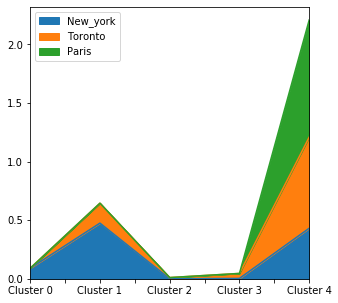

In [105]:
new.plot(kind='area',figsize=(5,5))

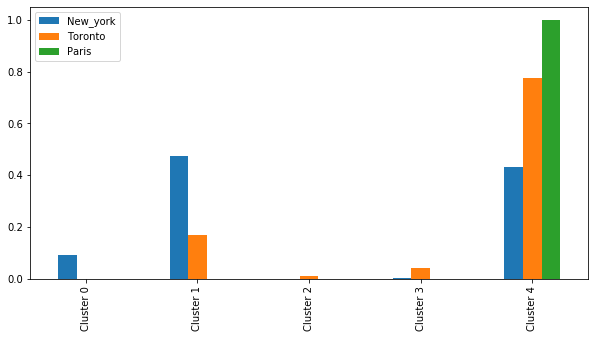

In [106]:
new.plot(kind='bar',figsize=(10,5))

In [147]:
#select all New York datasets in cluster 0, the evident theme is "Deli / Bodega"
#select all New York datasets in cluster 1, non-Manhattan boroughs are evident, let's take Brooklyn as an example, here you can find in Brooklyn theme "Caribbean restaurant"
#select all New York datasets in cluster 4, here you can find in Manhattan theme "foreign restaurant", Brooklyn theme "Pizza & Bar"

a=final[final['Assigned_cluster_index']==4]

#select all datasets in New_york
b=a[a['City_code']==0]

#select all datasets in Manhattan
c=b[b['Borough']=='Manhattan']
c

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Battery Park City,0,4,Manhattan,Park,Hotel,Gym,Wine Shop,Memorial Site,Boat or Ferry,Coffee Shop,Italian Restaurant,Gourmet Shop,Mexican Restaurant
58,Carnegie Hill,0,4,Manhattan,Coffee Shop,Café,Yoga Studio,Gym,Bookstore,Bakery,Cosmetics Shop,Pizza Place,Italian Restaurant,Japanese Restaurant
64,Central Harlem,0,4,Manhattan,French Restaurant,American Restaurant,Bar,African Restaurant,Seafood Restaurant,Chinese Restaurant,Spa,Fried Chicken Joint,Boutique,Market
66,Chelsea,0,4,Manhattan,Coffee Shop,Italian Restaurant,Art Gallery,American Restaurant,Ice Cream Shop,Bakery,Cycle Studio,Seafood Restaurant,Bar,Theater
67,Chinatown,0,4,Manhattan,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Salon / Barbershop,Dessert Shop,Hotpot Restaurant,Vietnamese Restaurant,Spa,Optical Shop
72,Civic Center,0,4,Manhattan,Coffee Shop,French Restaurant,Hotel,Cocktail Bar,Yoga Studio,American Restaurant,Park,Sushi Restaurant,Gym / Fitness Center,Spa
78,Clinton,0,4,Manhattan,Italian Restaurant,Coffee Shop,Theater,Gym / Fitness Center,Spa,Gym,Wine Shop,Hotel,Thai Restaurant,American Restaurant
107,East Harlem,0,4,Manhattan,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Latin American Restaurant,Park,Sandwich Place,Gym,Grocery Store,Donut Shop
111,East Village,0,4,Manhattan,Bar,Pizza Place,Mexican Restaurant,Wine Bar,Coffee Shop,Ice Cream Shop,Ramen Restaurant,Cocktail Bar,Speakeasy,Vegetarian / Vegan Restaurant
128,Financial District,0,4,Manhattan,Coffee Shop,Pizza Place,Bar,Cocktail Bar,Hotel,Gym / Fitness Center,Juice Bar,Park,American Restaurant,Japanese Restaurant


In [149]:
#select all Toronto datasets in cluster 4, for example, the evident theme is "Cafe" in Toronto downtown
#select all Toronto datasets in cluster 1, you will find groups outside'Downtown Toronto','East Toronto','West Toronto' and 'Central Toronto' are more evident, the theme mainly includes "Foreign restaurants"

#select all datasets in cluster 4
a=final[final['Assigned_cluster_index']==4]

#select all datasets containing Toronto name
d=a.loc[a['Borough'].isin(['Downtown Toronto','East Toronto','West Toronto','Central Toronto'])]

#select all datasets in Downtown Toronto
f=d.loc[d['Borough']=='Downtown Toronto']
d

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Berczy Park,1,4,Downtown Toronto,Coffee Shop,Bakery,Farmers Market,Cocktail Bar,Cheese Shop,Seafood Restaurant,Italian Restaurant,Beer Bar,Restaurant,Café
43,"Brockton, Parkdale Village, Exhibition Place",1,4,West Toronto,Café,Breakfast Spot,Coffee Shop,Yoga Studio,Restaurant,Stadium,Nightclub,Burrito Place,Furniture / Home Store,Grocery Store
50,Business reply mail Processing CentrE,1,4,East Toronto,Yoga Studio,Farmers Market,Gym / Fitness Center,Garden Center,Garden,Spa,Burrito Place,Fast Food Restaurant,Smoke Shop,Auto Workshop
53,"CN Tower, King and Spadina, Railway Lands, Har...",1,4,Downtown Toronto,Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Harbor / Marina,Bar,Plane,Boutique,Sculpture Garden,Airport Gate
63,Central Bay Street,1,4,Downtown Toronto,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Salad Place,Gym / Fitness Center,Japanese Restaurant,Spa,Bubble Tea Shop,Ice Cream Shop
68,Christie,1,4,Downtown Toronto,Grocery Store,Café,Park,Restaurant,Athletics & Sports,Gas Station,Diner,Coffee Shop,Candy Store,Baby Store
69,Church and Wellesley,1,4,Downtown Toronto,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Yoga Studio,Gastropub,Mediterranean Restaurant,Men's Store,Hotel
83,"Commerce Court, Victoria Hotel",1,4,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Gym,American Restaurant,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,Gastropub
93,Davisville North,1,4,Central Toronto,Food & Drink Shop,Convenience Store,Breakfast Spot,Gym,Sandwich Place,Park,Department Store,Hotel,Yoga Studio,Event Service
102,"Dufferin, Dovercourt Village",1,4,West Toronto,Bakery,Pharmacy,Brewery,Supermarket,Café,Middle Eastern Restaurant,Grocery Store,Park,Gym / Fitness Center,Bar


In [145]:
# select all datasets in cluster 4, in Paris boroughs of 'Butte-Montmartre','Elysee' and 'Vaugirard' as an example, the major theme is "French restaurant & hotel"

#select all datasets in cluster 4
a=final[final['Assigned_cluster_index']==4]

#select all datasets containing Paris name
g=a[a['City_code']==2]

#select all datasets in three boroughs where data density is high
i=g.loc[g['Borough'].isin(['Butte-Montmartre','Elysee','Vaugirard'])]
g

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Batignolles-Monceau,2,4,Batignolles-Monceau,French Restaurant,Hotel,Bakery,Italian Restaurant,Argentinian Restaurant,Breakfast Spot,Moroccan Restaurant,Bus Stop,Supermarket,Mediterranean Restaurant
37,Bourse,2,4,Bourse,French Restaurant,Hotel,Wine Bar,Cocktail Bar,Bistro,Bakery,Clothing Store,Coffee Shop,Creperie,Udon Restaurant
52,Buttes-Chaumont,2,4,Buttes-Chaumont,French Restaurant,Hotel,Bar,Pool,Italian Restaurant,Restaurant,Scenic Lookout,Supermarket,Park,Beer Garden
122,Entrepot,2,4,Entrepot,Hotel,French Restaurant,Cocktail Bar,Breakfast Spot,Seafood Restaurant,Bakery,Burger Joint,Bistro,Pizza Place,Coffee Shop
150,Gobelins,2,4,Gobelins,French Restaurant,Hotel,Italian Restaurant,Bar,Bakery,Café,Japanese Restaurant,Thai Restaurant,Supermarket,Greek Restaurant
152,Goutte d'Or,2,4,Butte-Montmartre,French Restaurant,Bistro,Supermarket,Convenience Store,Fast Food Restaurant,Café,Chinese Restaurant,Theater,Bakery,Asian Restaurant
163,Grenelle,2,4,Vaugirard,French Restaurant,Hotel,Bakery,Japanese Restaurant,Bistro,Italian Restaurant,Indian Restaurant,Cheese Shop,Creperie,Café
178,Hotel-de-Ville,2,4,Hotel-de-Ville,French Restaurant,Hotel,Clothing Store,Creperie,Ice Cream Shop,Pedestrian Plaza,Coffee Shop,Plaza,Garden,Wine Bar
195,Javel,2,4,Vaugirard,French Restaurant,Hotel,Pizza Place,Supermarket,Bakery,Japanese Restaurant,Restaurant,Asian Restaurant,Café,Bike Rental / Bike Share
218,Louvre,2,4,Louvre,Plaza,French Restaurant,Art Museum,Exhibit,Historic Site,Cosmetics Shop,Hotel,Clothing Store,Café,Coffee Shop


In [111]:
# To open up business in areas where many venues are densely located
business_newyork=final[final['City_code']==0]
business_newyork.groupby('Borough').count()

,Neighborhood,City_code,Assigned_cluster_index,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,
Bronx,52,52,52,52,52,52,52,52,52,52,52,52,52
Brooklyn,70,70,70,70,70,70,70,70,70,70,70,70,70
Manhattan,40,40,40,40,40,40,40,40,40,40,40,40,40
Queens,79,79,79,79,79,79,79,79,79,79,79,79,79
Staten Island,61,61,61,61,61,61,61,61,61,61,61,61,61


In [119]:
bn=business_newyork[business_newyork['Borough']=='Brooklyn']
bn[bn['Assigned_cluster_index']==1]

,Neighborhood,City_code,Assigned_cluster_index,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Bath Beach,0,1,Brooklyn,Pizza Place,Chinese Restaurant,Pharmacy,Italian Restaurant,Bubble Tea Shop,Sushi Restaurant,Gas Station,Fast Food Restaurant,Hookah Bar,Park
29,Bensonhurst,0,1,Brooklyn,Sushi Restaurant,Italian Restaurant,Pizza Place,Grocery Store,Donut Shop,Ice Cream Shop,Supermarket,Smoke Shop,Butcher,Coffee Shop
36,Borough Park,0,1,Brooklyn,Bank,Pizza Place,Café,Fast Food Restaurant,Pharmacy,Hotel,American Restaurant,Farmers Market,Hostel,Coffee Shop
42,Broadway Junction,0,1,Brooklyn,Diner,Fried Chicken Joint,Donut Shop,Dessert Shop,Nightclub,Caribbean Restaurant,Ice Cream Shop,Gas Station,Burger Joint,Sandwich Place
57,Canarsie,0,1,Brooklyn,Chinese Restaurant,Caribbean Restaurant,Gym,Grocery Store,Asian Restaurant,Factory,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
71,City Line,0,1,Brooklyn,Donut Shop,Grocery Store,Bakery,Shoe Store,Cuban Restaurant,Latin American Restaurant,Coffee Shop,Sandwich Place,Lingerie Store,Liquor Store
90,Crown Heights,0,1,Brooklyn,Pizza Place,Museum,Café,Burger Joint,Fried Chicken Joint,Supermarket,Candy Store,Bank,Bagel Shop,Coffee Shop
91,Cypress Hills,0,1,Brooklyn,Fried Chicken Joint,Ice Cream Shop,Donut Shop,Latin American Restaurant,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Supermarket,Baseball Field,Bank
95,Ditmas Park,0,1,Brooklyn,Caribbean Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Women's Store,Donut Shop,Metro Station,Liquor Store,Clothing Store,Dry Cleaner
108,East New York,0,1,Brooklyn,Gym,Fried Chicken Joint,Pizza Place,Event Service,Fast Food Restaurant,Plaza,Spanish Restaurant,Deli / Bodega,Pharmacy,Convenience Store


In [600]:
d.groupby('Borough').count()

,Neighborhood,City_code,Assigned_cluster_index,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,
Central Toronto,7,7,7,7,7,7,7,7,7,7,7,7,7
Downtown Toronto,18,18,18,18,18,18,18,18,18,18,18,18,18
East Toronto,5,5,5,5,5,5,5,5,5,5,5,5,5
West Toronto,6,6,6,6,6,6,6,6,6,6,6,6,6


In [601]:
g.groupby('Borough').count()

,Neighborhood,City_code,Assigned_cluster_index,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,
Batignolles-Monceau,1,1,1,1,1,1,1,1,1,1,1,1,1
Bourse,1,1,1,1,1,1,1,1,1,1,1,1,1
Butte-Montmartre,4,4,4,4,4,4,4,4,4,4,4,4,4
Buttes-Chaumont,1,1,1,1,1,1,1,1,1,1,1,1,1
Elysee,4,4,4,4,4,4,4,4,4,4,4,4,4
Entrepot,1,1,1,1,1,1,1,1,1,1,1,1,1
Gobelins,1,1,1,1,1,1,1,1,1,1,1,1,1
Hotel-de-Ville,1,1,1,1,1,1,1,1,1,1,1,1,1
Louvre,1,1,1,1,1,1,1,1,1,1,1,1,1
